In [1]:
# increase the cell width 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } </style>"))   
from simple_colors import *

### Convert hotpotqa to squard format

According to Longformer: use the following input format with special tokens:  “[CLS] [q] question [/q] [p] sent1,1 [s] sent1,2 [s] ... [p] sent2,1 [s] sent2,2 [s] ...” 
where [s] and [p] are special tokens representing sentences and paragraphs. The special tokens were added to the RoBERTa vocabulary and randomly initialized before task finetuning.

In [2]:
import tqdm 
from datetime import datetime 
import pytz 
timeZ_Az = pytz.timezone('US/Mountain') 

QUESTION_START = '[question]'
QUESTION_END = '[/question]' 
TITLE_START = '<t> , '  # indicating the start of the title of a paragraph (also used for loss over paragraphs)
TITLE_END = ', </t> . '   # indicating the end of the title of a paragraph, add , to avoid tilte to be recognized as part of the first entity in the sentence after
SENT_MARKER_END = ', </sent> , '  # indicating the end of the title of a sentence (used for loss over sentences)
PAR = '[/par]'  # used for indicating end of the regular context and beginning of `yes/no/null` answers
EXTRA_ANSWERS = " yes no null </s>"

In [3]:
import sys
sys.path.insert(0, '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages') 
 
from prettytable import PrettyTable
import ujson 
# import numpy
import spacy    
print(spacy.__version__)
import en_core_web_lg          
nlp1 = en_core_web_lg.load() 
nlp2 = en_core_web_lg.load() 

from spacy.symbols import ORTH, LEMMA, POS
nlp1.tokenizer.add_special_case('</sent>', [{ ORTH: '</sent>'}]) 
nlp1.tokenizer.add_special_case('</t>', [{ORTH: '</t>'}]) 
nlp1.tokenizer.add_special_case('<t>', [{ORTH: '<t>'}])  
import neuralcoref 
neuralcoref.add_to_pipe(nlp1, greedyness=0.53) # between 0 and 1. The default value is 0.5.



# Fan: make 3 changes in pytextrank.py ( '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.8/site-packages/pytextrank')
# 1. phrase_text = ' '.join(key[0] for key in phrase_key) 
#  p.text are the joint of lemma tokens with pos_ in kept_pos, and maintain the order when join    
# 2. add argumrnt 'chunk_type' to only consider named entity ('ner') or noun_chunks ('noun'), besides the default ('both') 
# 3. replace token.lemma_ with token.lemma_.lower().strip()
import pytextrank
tr = pytextrank.TextRank(pos_kept=["ADJ", "NOUN", "PROPN", "VERB", "NUM", "ADV"], chunk_type='both')  
nlp2.add_pipe(tr.PipelineComponent, name='textrank', last=True)


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten

#!conda install networkx --yes
import networkx as nx
from networkx.readwrite import json_graph
import itertools 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from fuzzywuzzy import utils

2.3.5


/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
import imp
imp.find_module('neuralcoref')

(None, '/home/u32/fanluo/neuralcoref/neuralcoref', ('', '', 5))

In [5]:
import imp
imp.find_module('pytextrank')

(None,
 '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages/pytextrank',
 ('', '', 5))

In [6]:
import imp
imp.find_module('spacy')

(None,
 '/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/lib/python3.7/site-packages/spacy',
 ('', '', 5))

### Compute the reduced context with phrase graph

In [9]:
### Compute the reduced context with phrase graph

import re
import string

from networkx.algorithms import approximation as approx
def reduce_context_with_phares_graph(example, q_id):
    """function to compute reduced context with phrase graph.

    Args:
        json_dict: The original data load from hotpotqa file.
        gold_paras_only: when is true, only use the 2 paragraphs that contain the gold supporting facts; if false, use all the 10 paragraphs
 
    Returns:
        a new file save additional phrase-related info and the reduced context

    """
#     noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
#     new_dict = {"data": []} 
#     data = []
#     common_phrases_num_le2 = 0
#     extended = 0
#     answer_in_reduced_context = 0
#     answer_in_context = 0
#     reduced_context_ratios = []
    
#     question = "Who was the writer of 'These Boots Are Made for Walkin' and who died in 2007?"
#     question = example["question"]
#     question_doc = nlp2(question)
    
#     question_phrases_text = set([basic_normalize(entity.text) for entity in question_doc.ents])
#     for chunk in question_doc.noun_chunks:
#         question_phrases_text.add(basic_normalize(chunk.text))
#     question_phrases_text = list(question_phrases_text)
    
    question = basic_normalize(example["question"])
    print("question: ", question)
    question_doc = nlp2(question)
    question_phrases = [(_normalize_text(p.text.lower()), p.rank) for p in question_doc._.phrases if(p.text != '')] 
    question_phrases_text = [p[0] for p in question_phrases] 
             
    print(black("Original question: ", 'bold'), example["question"])
    print(black("question: ", 'bold'), question)
    print(black("question_phrases_text: ", 'bold'), question_phrases_text)
#     print(black("question_phrases: ", 'bold'), question_phrases)
    answer = _normalize_text(example["answer"]) 
    print(black('answer: ', 'bold'), answer)    

    raw_contexts = example["context"]
#         if gold_paras_only: 
#        raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    
    paras_phrases = []                                                # phrases of all 10 paragraghs
    titles = []
    num_paras_didnot_use_resolve = 0
    paras_didnot_use_resolve = []
    for i, para_context in enumerate(raw_contexts):                   # each para
#         print(black('title: ', 'bold'), para_context[0]) 
#         print(black("original sents: " , 'bold'), para_context[1])
        titles.append(para_context[0])
        title = basic_normalize(para_context[0])   
        
        sents = [ basic_normalize(sent) for sent in para_context[1]]
        num_sents_before_coref_resolved = len(sents)
#         print("numbe of sents before coref: ", num_sents_before_coref_resolved)
        sents_joint =  (' ' + SENT_MARKER_END +' ').join(sents)
        
#         print(black("normalized sents: " , 'bold'), sents_joint)
        sents_doc = nlp1(sents_joint)
#         print(black("resolved_sents: ", 'bold'), sents_doc._.coref_resolved ) 
        sents_coref_resolved = sents_doc._.coref_resolved.split(SENT_MARKER_END)
        num_sents_after_coref_resolved = len(sents_coref_resolved)
        
#         print("numbe of sents after coref: ", num_sents_after_coref_resolved)
        
 
        if(num_sents_before_coref_resolved == num_sents_after_coref_resolved):
            sent_docs = list(nlp2.pipe([title] + sents_coref_resolved))       
        else:
            sent_docs = list(nlp2.pipe([title] + sents))
            num_paras_didnot_use_resolve += 1
            paras_didnot_use_resolve.append(i)
            print('paras_didnot_use_resolve')
 
        para_phrases = []                                        
        for sent_doc in sent_docs:                                      # each sent in a para 
            sent_phrases = [(_normalize_text(p.text), p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
            para_phrases.append(sent_phrases)                                # para_phrases[0] are phrases from  title
        paras_phrases.append(para_phrases)     
    print(black("paras_phrases", 'bold'))
    for paras_phrase in paras_phrases: 
        print([list(flatten(s))[::2] for s in paras_phrase])
        
#     contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_contexts]  
#     context = " ".join(contexts)                                                     
#     if (answer != '' and len(list(re.finditer(answer, context, re.IGNORECASE))) > 0):
#         answer_in_context += 1
#     all_sent_phrases_text =  list(flatten(paras_phrases))[::2]        # every other element is text, others are rank 
    
    RG = create_relevant_graph(paras_phrases, question_phrases_text)
    RG, common_phrases, mapping = find_common_mapping(RG, question_phrases_text)# mapping matchs paras_phrases with question_phrases

    
    
    RG, dup_sets = dedup_nodes_in_graph(RG, question_phrases_text)              # dedup paras_phrases in RG for finding meanningful path
#     print(black("nodes in RG: ", 'bold'), RG.nodes())
    
    question_only_phrase = list(set(question_phrases_text).difference(common_phrases)) 
    if(len(common_phrases) > 1): 
        path_phrases = list(approx.steinertree.steiner_tree(RG, common_phrases).nodes)  # to find the shortest path cover all common_phrases  
        extended_phrases = path_phrases + question_only_phrase  
    else: #  0 or 1 common phrases
        path_phrases = list(common_phrases)             
        extended_phrases = question_phrases_text

    
    print(black("common_phrases: ", 'bold'), common_phrases)
    print(black("path_phrases: ", 'bold'), path_phrases)     
    print(black("question_only_phrase: ", 'bold'), question_only_phrase)
    print(black("extended_phrases before expand", 'bold'), extended_phrases)
    
    # expand to include previously mapped nodes 
    reversed_mapping = {} 
    for k,v in mapping.items():
        if v in reversed_mapping:
            reversed_mapping[v].append(k)
        else:
            reversed_mapping[v] = [k] 
    for phrase in extended_phrases: 
        if phrase in reversed_mapping:
            extended_phrases.extend(reversed_mapping[phrase])
    
    # futher expand to include merged nodes, that is, also include phrases that from the same dup_set 
    extended_phrases_merged = set()
    for phrase in extended_phrases:
        idx_phrase = [idx for idx, dup_set in enumerate(dup_sets) if(phrase in dup_set)]   # idx_phrase[0]: idx of the set where phrase in
        if(len(idx_phrase) > 0):
            extended_phrases_merged = extended_phrases_merged | dup_sets[idx_phrase[0]]    # merge sets
            extended_phrases_merged.remove(phrase)
    extended_phrases.extend(list(extended_phrases_merged))
    print(black("extended_phrases: ", 'bold'), extended_phrases)        
    print(black("introduced_phrases: ", 'bold'), set(extended_phrases) - set(question_phrases_text))
        
    vis_graph(RG, common_phrases, question_phrases_text) 
#     print(blue("Min Subgraph covers all common entities"))
    vis_graph(RG, path_phrases, question_phrases_text) 
        
#     print(black("phrases in relevant components", 'bold'))    
#     print(RG.nodes.data())
        
        
    raw_reduced_contexts, kept_para_sent = construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping)     
    reduced_contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_reduced_contexts]    
    reduced_context_str = _normalize_text(" ".join(reduced_contexts))  
    if (answer != '' and answer != 'yes'  and  answer != 'no' and len(list(re.finditer(answer, reduced_context_str, re.IGNORECASE))) > 0):
        print(black("answer in reduced_context", 'bold')) 
    elif(answer == 'yes' or answer == 'no'):
        pass
    else:
        print(black("answer not in reduced_context", 'bold')) 
        print(black("reduced_contexts", 'bold'), raw_reduced_contexts)
    print(black('titles: ', 'bold'), titles) 
    
    reduced_supporting_facts, reduced_supporting_facts_in_original_sentId = construct_reduced_supporting_facts(example["supporting_facts"], raw_reduced_contexts, kept_para_sent) 
    for para_title, sent_id in example["supporting_facts"]:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    print(black('reduced_supporting_facts_in_original_sentId: ', 'bold'), reduced_supporting_facts_in_original_sentId) 
#     print(black('reduced supportiing facts: ', 'bold'), reduced_supporting_facts) 
    for para_title, sent_id in reduced_supporting_facts_in_original_sentId:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    
#     example["question_phrases_text"] = question_phrases_text
#     example["question_only_phrase"] = question_only_phrase
#     P = RG.subgraph(path_phrases)  # to save the graph view that contains      
#     path_data = json_graph.node_link_data(P)
#     example["path"] = path_data
#     example["question_phrases"] = question_phrases
#     example["paras_phrases"] = paras_phrases
# #     example["all_sent_phrases_text"] = all_sent_phrases_text
#     example["common_phrases"] = list(common_phrases)
#     example["path_phrases"] = path_phrases
#     example["extended_phrases"] = extended_phrases                     
#     example['context'] = raw_reduced_contexts
#     example['supporting_facts'] = reduced_supporting_facts
#     example['kept_para_sent'] = kept_para_sent

    print(black("context: ", 'bold'), raw_contexts)   
    print(black("reduced_context: ", 'bold'), raw_reduced_contexts)   
    
#     data.append(example)  
#     with open("/home/u32/fanluo/Jupyter/experiments/transformers/outfile.json", 'w') as out_file:
#         json.dump(data, out_file)
        
    return num_paras_didnot_use_resolve, paras_didnot_use_resolve

#### Helper functions

In [10]:
# revised for extractiing phrases, case matters for phrases extraction
def lower(text):
    return text.lower()

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)
 
def basic_normalize(s):
    def white_space_fix(text):
        return ' '.join(text.split())

    def replace_special_punc(text):
        sentence_end = set(['.', '?', '!'])
        chs = []
        for ch in str(text):
            if ch in sentence_end:
                chs.append(',')
            elif ch == '-':
                chs.append(' ')
            else:
                chs.append(ch)
        
        return ''.join(chs)

#     def remove_stop_words(text):
#         all_stopwords = set(nlp.Defaults.stop_words)
#         return ' '.join(word for word in text.split() if word not in all_stopwords) 
    def remove_wh_words(text):
        wh_words = set(["what", "when", 'where', "which", "who", "whom", "whose", "why", "how", "whether",
                        "What", "When", 'Where', "Which", "Who", "Whom", "Whose", "Why", "How", "Whether"])
        return ' '.join(word for word in text.split() if word not in wh_words) 

    return white_space_fix(remove_wh_words(replace_special_punc(str(s))))

def _normalize_text(s):
    return basic_normalize(remove_articles(remove_punc(lower(str(s)))))

In [11]:
# healper function
def inclusion_best_match(query, choices):
    if (utils.full_process(query) and choices != []):  # only exectute when query is valid. To avoid WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0.
        inclusion_phrases = [simi_phrase for (simi_phrase, similarity) in process.extractBests(query, choices, scorer=fuzz.token_set_ratio) if similarity ==100]  # match '1977 film' and '1977', but will not match substring 'woman' and 'businesswoman', avid nosiy such as 'music' and 'us'
        if(inclusion_phrases!= []):
            simi_phrase, similarity = process.extractOne(query, inclusion_phrases, scorer=fuzz.ratio) # most similar   
            query_len = len(query.split())
            simi_phrase_len = len(simi_phrase.split())
            if(query_len > 0 and simi_phrase_len > 0):
                len_ratio = min(query_len/simi_phrase_len , simi_phrase_len/query_len)
                if(similarity >= len_ratio * 100):     # similarity of 'book' and 'second companion book' is 32 < 1/3 * 100
                    return simi_phrase
 
    return None
        

#### create_relevant_graph

In [7]:
def create_para_graph(paras_phrases):
    G = nx.Graph()     
    for pi, para_phrases in enumerate(paras_phrases):        # each para 
        for si, sent_phrases in enumerate(para_phrases):     # each sent
            
            # complete graph for each sent
            G.add_nodes_from([(phrase[0], {"score": phrase[1]}) for phrase in sent_phrases])  
            for node1, node2 in itertools.combinations([phrase[0] for phrase in sent_phrases], 2):
                if(G.has_edge(node1, node2)):
                    G[node1][node2]['src'].append((pi, si))
                else:
                    G.add_edge(node1, node2, src = [(pi, si)])
                                               
                                                
            # add edge between title phrases and first phrase of the sentence
            # si = 0, sent_phrases = para_phrases[0] are phrases from title 
            for phrase in para_phrases[0]:
                if(len(sent_phrases) > 0 and sent_phrases[0] != phrase):
                    if(G.has_edge(sent_phrases[0], phrase)):
                        G[sent_phrases[0]][phrase]['src'].append((pi, 'title', si))
                    else:
                        G.add_edge(sent_phrases[0], phrase, src = [(pi, 'title', si)]) 
     
 
  #  Draw
    print(blue("Paragraph phrase graph" , ['bold']))
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    nx.draw(G, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
    
    
    
    return G


In [12]:
def create_relevant_graph(paras_phrases, question_phrases_text):
    G = create_para_graph(paras_phrases)
    Subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    RG = nx.Graph()    # relevant components  
    represnetive_nodes = []  # more likely to include the represnetive_nodes in the final path       
    for S in Subgraphs:
        for phrase in question_phrases_text:
            if S.has_node(phrase):
                RG = nx.compose(RG, S)  # joint the relevant components
                represnetive_node = sorted(S.nodes.data('score'), key=lambda x: x[1], reverse=True)[0]  # node with highest score
                represnetive_nodes.append(represnetive_node) 
                break
    
    for node1, node2 in itertools.combinations([phrase[0] for phrase in represnetive_nodes], 2):  
        RG.add_edge(node1, node2, source = 'components')

 
    #  Draw Relevant components graph RG
#     print(blue('Relevant components graph'))
    pos = nx.spring_layout(RG)
    plt.figure(figsize=(20,10))
    nx.draw(RG, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
#     print(black("nodes in joined components: ", 'bold'), RG.nodes())   
    return RG

In [8]:
def vis_graph(H, nodes, color_nodes):
    
    G = H.subgraph(nodes)  # Returns a subgraph containing nodes in nbunch
    print(black("nodes to draw", ['bold']), G.nodes())
    
    plt.figure(figsize=(20,10))
    color_map = dict.fromkeys(color_nodes, "grey")   
    values = [color_map.get(node, "yellow" ) for node in G.nodes()]  # beside color_nodes are "grey", other nodes are "yellow"
    pos = nx.random_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'source')
    nx.draw(G, pos, node_color=values, with_labels=True, node_size=800, font_size=20, font_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15) 
    plt.show() 
     
    for n, nbrs in G.adj.items():  # each node and its neighbors   
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            print(f"({n}, {nbr}, {eattr})")
            
    return

#### find_common_mapping

In [13]:
def find_common_mapping(G, question_phrases_text):
    # fuzzy macth for common phrases: map pharse similar to question phrases to question phrase, then find common phrases
    common_phrases = set()
    mapping = {}
    for phrase in G.nodes:
        if(phrase in question_phrases_text):    # has a exact match
            common_phrases.add(phrase)
            continue
            
        # check partial match
        inclusion_similar_phrase = inclusion_best_match(phrase, question_phrases_text)
        if(inclusion_similar_phrase): 
            mapping[phrase] = inclusion_similar_phrase   
            common_phrases.add(inclusion_similar_phrase)
    
    G = nx.relabel_nodes(G, mapping)      # match 'english government position' with 'government position'
    print(black("node mapping for RG: ", 'bold'), mapping)
    
    return G, common_phrases, mapping

#### dedup_nodes_in_graph

In [14]:
def dedup_nodes_in_graph(G, grounded):
    def find_inclusion_duplicates(contains_dupes): 
        dup_sets = []
        for phrase in contains_dupes:
            rest_phrases = [p for p in contains_dupes if p != phrase] 
            inclusion_similar_phrase = inclusion_best_match(phrase, rest_phrases)
            if(inclusion_similar_phrase): 
                idx_phrase = [idx for idx, set in enumerate(dup_sets) if(phrase in set)]   # the set where phrase already in
                idx_inclusion_similar_phrase = [idx for idx, set in enumerate(dup_sets) if(inclusion_similar_phrase in set)]
                # idx_phrase and idx_inclusion_similar_phrase would be 0 or 1
#                 if(len(idx_phrase) > 1):
#                     print("len(idx_phrase) > 1, phrase: ", phrase)
#                     for i in idx_phrase:
#                         print(dup_sets[i])
#                 if(len(idx_inclusion_similar_phrase) > 1):
#                     print("len(idx_inclusion_similar_phrase) > 1, inclusion_similar_phrase: ", inclusion_similar_phrase)
#                     for i in idx_inclusion_similar_phrase:
#                         print(dup_sets[i])
                if(len(idx_phrase) > 0 and len(idx_inclusion_similar_phrase) == 0):
                    dup_sets[idx_phrase[0]].add(inclusion_similar_phrase)
                elif(len(idx_inclusion_similar_phrase) > 0 and len(idx_phrase) == 0):
                    dup_sets[idx_inclusion_similar_phrase[0]].add(phrase)
                elif(len(idx_inclusion_similar_phrase) > 0 and len(idx_phrase) > 0):
                    if(idx_phrase[0] != idx_inclusion_similar_phrase[0]):
                        dup_sets[idx_phrase[0]] = dup_sets[idx_phrase[0]] | dup_sets[idx_inclusion_similar_phrase[0]]   # merge sets
                        dup_sets.pop(idx_inclusion_similar_phrase[0])
                elif(len(idx_inclusion_similar_phrase) == 0 and len(idx_phrase) == 0):
                    dup_sets.append(set([phrase, inclusion_similar_phrase]))
                else:
                    print("len(idx_inclusion_similar_phrase), len(idx_phrase)")
                    print(len(idx_inclusion_similar_phrase), len(idx_phrase) )
           
                
        # dup_sets would looks like:  [{'1977 film', '1977', 'film'},  {'anime', 'japanese anime'}]

        print(black("dup_sets: ", 'bold'), dup_sets)
        
        return dup_sets

    def merge_dup_nodes(G, dup_sets, grounded):

        for node_sets in dup_sets:     
            assert len(node_sets) >= 2
            # for each set, decide which one to be merged to
            # longest phrase that is same as a question phrase 
            merged_node = sorted([p for p in node_sets if p in grounded], key=lambda x: len(x), reverse=True)
            if(len(merged_node) == 0):   
                merged_node = sorted(node_sets, key=lambda x: len(x), reverse=True) # longest node
                        
            # merged_node[0] is the node to be merged to for current node_set
            for n in node_sets:
                if(n != merged_node[0]):
                    G = nx.contracted_nodes(G, merged_node[0], n)   # merge node
                        
        return G
    
    dup_sets = find_inclusion_duplicates(G.nodes)
    return merge_dup_nodes(G, dup_sets, grounded), dup_sets

#### construct_reduced_context

In [15]:
def construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping):    
    raw_reduced_contexts = []     # sentences contain one of the extended_phrases
    number_sentences = 0
    number_reduced_sentences = 0 
    kept_para_sent = []
    for para_id, (para_title, para_lines) in enumerate(raw_contexts):
# #             print("para_id, para_title, para_lines",para_id, para_title, para_lines)

        number_sentences += len(para_lines)
        reduced_para = []
        kept_sent = []
        for sent_id, sent in enumerate(para_lines):
            sentence_phrases = list(flatten(paras_phrases[para_id][sent_id+1]))[::2]  # paras_phrases[para_id][0] are phrases from the title, every other element is text, others are rank  

#                 print("sentence_phrases: ", sentence_phrases)
#                 print('[sentence_phrase in mapping for sentence_phrase in sentence_phrases]: ', [sentence_phrase in mapping for sentence_phrase in sentence_phrases])
            if(any([sentence_phrase in mapping for sentence_phrase in sentence_phrases])): # at least one of sentence_phrase mapped to question phrase
                reduced_para.append(sent)
                number_reduced_sentences += 1 
                kept_sent.append(sent_id)
                continue

            for phrase in extended_phrases:                    
                if(phrase in sentence_phrases):  # current sentence has a exact match to extended_phrases 
                    reduced_para.append(sent)
                    number_reduced_sentences += 1 
                    kept_sent.append(sent_id)
                    break     # no need to continue checking whether current sentence contains other extended_phrases

 
        if(len(reduced_para) > 0):
            raw_reduced_contexts.append([para_title, reduced_para])
            kept_para_sent.append(kept_sent)
        else:
            for phrase in extended_phrases:
                if(phrase in list(flatten(paras_phrases[para_id][0]))[::2]):   # only tilte contains one of the extended_phrases
                    raw_reduced_contexts.append([para_title, []])
                    kept_para_sent.append(kept_sent)
                    break
                     
      
    assert number_reduced_sentences <= number_sentences   
    print(black('reduced_context_ratio', 'bold'), number_reduced_sentences / number_sentences)    

    return raw_reduced_contexts, kept_para_sent

#### construct_reduced_supporting_facts

In [16]:
def construct_reduced_supporting_facts(supporting_facts, reduced_contexts, kept_para_sent):
    
    reduced_supporting_facts = []
    reduced_supporting_facts_in_original_sentId = []
    support_para = set(
        para_title for para_title, _ in supporting_facts
    )
    sp_set = set(list(map(tuple, supporting_facts)))                              # a list of (title, sent_id in orignal context) 
    print(black('supportiing facts: ', 'bold'), sp_set) 
    for i, para_reduced_context in enumerate(reduced_contexts):                   # each para
        if(para_reduced_context[0] in support_para):
            for sent_id, orig_sent_id in enumerate(kept_para_sent[i]):
                if( (para_reduced_context[0], orig_sent_id) in sp_set ):
                    reduced_supporting_facts.append([para_reduced_context[0], sent_id])
                    reduced_supporting_facts_in_original_sentId.append([para_reduced_context[0], orig_sent_id])
                    
    return reduced_supporting_facts, reduced_supporting_facts_in_original_sentId

### Run

In [17]:
# ### Compute the reduced context with phrase graph# debug: check args
# import shlex
# # argString ='--datafile /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json --qid 5ade28cf5542997c77aded85'  # --outfile /xdisk/msurdeanu/fanluo/hotpotQA/small_out.json'
# argString ='--datafile /xdisk/msurdeanu/fanluo/hotpotQA/Data/train100.json'    
# # hotpot_train_v1.1.json

# shlex.split(argString)

# import json
# import argparse 
# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--datafile", type=str, default='small.json')
#     parser.add_argument("--qid", type=str, default='5ae73acb5542991e8301cc07')
# #    parser.add_argument("--outfile", type=str, default='small_out.json')
#     args = parser.parse_args(shlex.split(argString)) 
# #     print(args.datafile)
# #     print(args.qid)

#     with open(args.datafile, "r", encoding='utf-8') as f:  
#         num_paras_didnot_use_resolve = 0
#         paras_didnot_use_resolve = []
#         for e_id, example in enumerate(json.load(f)): 
#             num_paras_didnot_use_resolve_i, paras_didnot_use_resolve_i = reduce_context_with_phares_graph(example, example['_id'])
#             num_paras_didnot_use_resolve += num_paras_didnot_use_resolve_i
#             paras_didnot_use_resolve.append(paras_didnot_use_resolve_i)
#     print('num_paras_didnot_use_resolve: ', num_paras_didnot_use_resolve)
#     print('paras_didnot_use_resolve: ', paras_didnot_use_resolve)

# if __name__ == "__main__": 
#     main()

In [18]:
# question_json = !/xdisk/msurdeanu/fanluo/helper/jq-linux64 -c '.[] | select(._id | contains("5abee5e25542994516f45473"))' /xdisk/msurdeanu/fanluo/hotpotQA/Data/train100.json
# example = ujson.loads(question_json[0]) 
# reduce_context_with_phares_graph(example, '5a7a06935542990198eaf050')

In [19]:
question_json = !/xdisk/msurdeanu/fanluo/helper/jq-linux64 -c '.[] | select(._id | contains("5abf63f15542997ec76fd3ea"))' /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json
example = ujson.loads(question_json[0]) 
example

{'_id': '5abf63f15542997ec76fd3ea',
 'answer': 'October 1922',
 'question': 'Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of a civil war that ended when ?',
 'supporting_facts': [['Socialist Revolutionary Party', 5],
  ['Russian Civil War', 0]],
 'context': [['Socialist Revolutionary Party',
   ['The Socialist Revolutionary Party, or Party of Socialists-Revolutionaries (the SRs; Russian: Партия социалистов-революционеров (ПСР), эсеры , "esery") was a major political party in early 20th century Russia and a key player in the Russian Revolution.',
    ' Its general ideology was revolutionary socialism of democratic socialist and agrarian socialist forms.',
    ' After the February Revolution of 1917, it shared power with other liberal and democratic socialist forces within the Russian Provisional Government.',
    " In November 1917, it won a plurality of the national vote in Russia's first-ever democratic elections (to the Russian Constituent Assembly), 

### reduce_context_with_phares_graph() zoom in

In [20]:
    question = basic_normalize(example["question"])
    print("question: ", question)
    print("type: ", example["level"])

question:  Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of a civil war that ended ,
type:  hard


In [21]:
    
    question_doc = nlp2(question)
    

In [22]:
    question_phrases = [(_normalize_text(p.text), p.rank) for p in question_doc._.phrases if(p.text != '')] 
    question_phrases_text = [p[0] for p in question_phrases] 
             
    print(black("Original question: ", 'bold'), example["question"])
    print(black("question: ", 'bold'), question)
    print(black("question_phrases_text: ", 'bold'), question_phrases_text)
#     print(black("question_phrases: ", 'bold'), question_phrases)

Original question:  Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of a civil war that ended when ?
question:  Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of a civil war that ended ,
question_phrases_text:  ['alexander kerensky', 'bolsheviks', 'course', 'war', 'civil war']


In [23]:
    answer = _normalize_text(example["answer"])
    print(black('answer: ', 'bold'), answer)    

answer:  october 1922


In [24]:
    raw_contexts = example["context"]

In [25]:
#         if gold_paras_only: 
#        raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    
paras_phrases = []                                                # phrases of all 10 paragraghs
titles = []
for i, para_context in enumerate(raw_contexts):                   # each para
    titles.append(para_context[0])
    title = basic_normalize(para_context[0])   
    print(black('title: ', 'bold'), para_context[0]) 
    print(black("original sents: " , 'bold'), para_context[1])
    
    sents = [ basic_normalize(sent) for sent in para_context[1]]
    num_sents_before_coref_resolved = len(sents)
    print("number of sents before coref: ", num_sents_before_coref_resolved)
    sents_joint =  (' ' + SENT_MARKER_END +' ').join(sents)

    print(black("normalized sents: " , 'bold'), sents_joint)
    sents_doc = nlp1(sents_joint)
    print(black("resolved_sents: ", 'bold'), sents_doc._.coref_resolved ) 
    sents_coref_resolved = sents_doc._.coref_resolved.split(SENT_MARKER_END)
    num_sents_after_coref_resolved = len(sents_coref_resolved)
    
   
    print("number of sents after coref: ", num_sents_after_coref_resolved)


    if(num_sents_before_coref_resolved == num_sents_after_coref_resolved):
        sent_docs = list(nlp2.pipe([title] + sents_coref_resolved))       
    else:
        print(black('Did not use resolved sentences', 'bold'))
        sent_docs = list(nlp2.pipe([title] + sents))

    para_phrases = []                                        
    for sent_doc in sent_docs:                                      # each sent in a para 
        sent_phrases = [(_normalize_text(p.text), p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
        para_phrases.append(sent_phrases)                                # para_phrases[0] are phrases from  title
    paras_phrases.append(para_phrases)     
print(black("paras_phrases", 'bold'))


title:  Socialist Revolutionary Party
original sents:  ['The Socialist Revolutionary Party, or Party of Socialists-Revolutionaries (the SRs; Russian: Партия социалистов-революционеров (ПСР), эсеры , "esery") was a major political party in early 20th century Russia and a key player in the Russian Revolution.', ' Its general ideology was revolutionary socialism of democratic socialist and agrarian socialist forms.', ' After the February Revolution of 1917, it shared power with other liberal and democratic socialist forces within the Russian Provisional Government.', " In November 1917, it won a plurality of the national vote in Russia's first-ever democratic elections (to the Russian Constituent Assembly), but the October Revolution had changed the political landscape and the Bolsheviks disbanded the Constituent Assembly in January 1918.", ' The SRs soon split into pro-Bolshevik and anti-Bolshevik factions.', ' The anti-Bolshevik faction of this party, known as the Right SRs, which remai

title:  Left-wing uprisings against the Bolsheviks
original sents:  ['The left-wing uprisings against the Bolsheviks were a series of rebellions and uprisings against the Bolsheviks by rival left-wing parties that started soon after the October Revolution, continued through the Russian Civil War, and lasted into the first few years of Soviet rule.', ' They were led or supported by left-wing groups such as some factions of the Socialist Revolutionary Party, Left Socialist Revolutionaries, Mensheviks, and anarchists.', ' The uprisings started in 1918 and continued during and after the Civil War until around 1924.', ' The Bolsheviks increasingly abandoned attempts to invite these groups to join the government and instead suppressed them with force.']
number of sents before coref:  4
normalized sents:  The left wing uprisings against the Bolsheviks were a series of rebellions and uprisings against the Bolsheviks by rival left wing parties that started soon after the October Revolution, con

title:  Kerensky–Krasnov uprising
original sents:  ['Kerensky–Krasnov uprising was an attempt by Alexander Kerensky to regain power after the Bolsheviks overthrew his Provisional Government in Petrograd.']
number of sents before coref:  1
normalized sents:  Kerensky–Krasnov uprising was an attempt by Alexander Kerensky to regain power after the Bolsheviks overthrew his Provisional Government in Petrograd,
resolved_sents:  Kerensky–Krasnov uprising was an attempt by Alexander Kerensky to regain power after the Bolsheviks overthrew Bolsheviks Provisional Government in Petrograd,
number of sents after coref:  1
title:  Russian Civil War
original sents:  ['The Russian Civil War (Russian: Гражда́нская война́ в Росси́и , "Grazhdanskaya voyna v Rossiyi" ; November 1917 – October 1922) was a multi-party war in the former Russian Empire immediately after the Russian Revolutions of 1917, as many factions vied to determine Russia\'s political future.', ' The two largest combatant groups were the 

title:  Alexander Kerensky
original sents:  ['Alexander Fyodorovich Kerensky (Russian: Алекса́ндр Фёдорович Ке́ренский , ] ; 4 May 1881 – 11 June 1970) was a Russian lawyer and key political figure in the Russian Revolution of 1917.', " After the February Revolution of 1917 he joined the newly formed Russian Provisional Government, first as Minister of Justice, then as Minister of War, and after July 1917 as the government's second Minister-Chairman.", ' A leader of the moderate-socialist Trudoviks faction of the Socialist Revolutionary Party, he was also vice-chairman of the powerful Petrograd Soviet.', ' On 7 November, his government was overthrown by the Lenin-led Bolsheviks in the October Revolution.', ' He spent the remainder of his life in exile, in Paris and New York City, and worked for the Hoover Institution.']
number of sents before coref:  5
normalized sents:  Alexander Fyodorovich Kerensky (Russian: Алекса́ндр Фёдорович Ке́ренский , ] ; 4 May 1881 – 11 June 1970) was a Russ

In [26]:
sp_set = set(list(map(tuple, example["supporting_facts"])))   
sp_loc = []         # a boolean list with True/False elements, one for each context sentence
for pi, (para_title, para_lines) in enumerate(raw_contexts): 
    sp_loc.append([])
    for sent_id, sent in enumerate(para_lines):
        sp_loc[pi].append( (para_title, sent_id) in sp_set )      
# print('sp_loc: ', sp_loc)

supporting_facts_phrases = []
for pi, paras_phrase in enumerate(paras_phrases): 
    print([list(flatten(paras_phrase[0]))[::2]]) # paras_phrase[0]: title phrases
    for si, s in enumerate(paras_phrase[1:]):  
#         print('s: ', s)
        if(sp_loc[pi][si]):
            print(black(list(flatten(s))[::2], 'bold')) 
            supporting_facts_phrases.append(list(flatten(s))[::2])
        else:
            print(list(flatten(s))[::2])
    print("\n")

[['socialist revolutionary party']]
['early 20th century', 'партия социалистов революционеров', 'socialists revolutionaries', 'russia', 'party', 'пср', 'revolutionaries', 'russian', 'party socialists revolutionaries', 'socialist revolutionary party', 'player', 'эсеры', 'major political party', 'sr', 'esery', 'key player', 'russian revolution']
['revolutionary socialism', 'democratic socialist agrarian socialist form', 'ideology', 'socialism', 'russia general ideology', 'russia', 'form']
['other liberal democratic socialist force', 'power', 'force', 'russia', 'russian provisional government', 'revolution', 'february revolution 1917', 'february revolution']
['russia', 'november 1917', 'russia first ever democratic election', 'january 1918', 'russian constituent assembly', 'first', 'landscape', 'constituent assembly', 'bolsheviks', 'plurality', 'january', 'election', 'democratic', 'revolution', 'vote', 'november', 'february revolution 1917', 'political landscape', 'national vote', 'februa

In [27]:
print(black('supportiing facts_text:', 'bold')) 
for para_title, sent_id in example["supporting_facts"]:
    print(raw_contexts[titles.index(para_title)][1][sent_id])
print(black("supporting_facts_phrases:", 'bold'))
for sp_phrase in supporting_facts_phrases:
    print(sp_phrase)

supportiing facts_text:
 The anti-Bolshevik faction of this party, known as the Right SRs, which remained loyal to the Provisional Government leader Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of the Russian Civil War and subsequent persecution.
The Russian Civil War (Russian: Гражда́нская война́ в Росси́и , "Grazhdanskaya voyna v Rossiyi" ; November 1917 – October 1922) was a multi-party war in the former Russian Empire immediately after the Russian Revolutions of 1917, as many factions vied to determine Russia's political future.
supporting_facts_phrases:
['alexander kerensky', 'provisional government leader alexander kerensky', 'subsequent persecution', 'faction', 'kerensky', 'russian civil war', 'srs', 'bolshevik', 'party', 'bolsheviks', 'course', 'persecution', 'right srs', 'anti bolshevik faction']
['гражда́нская война́ в', 'many faction', 'rossiyi', 'russia', 'november 1917 october 1922', 'russian civil war', 'war', 'october', 'november', 'empir

Paragraph phrase graph
node mapping for RG:  {'provisional government leader alexander kerensky': 'alexander kerensky', 'kerensky': 'alexander kerensky', 'russian civil war': 'civil war', 'bolsheviks leader': 'bolsheviks', 'world war i': 'war', 'ensue russian civil war': 'civil war', 'alexander kerensky provisional government': 'alexander kerensky', 'russian bolsheviks': 'bolsheviks', 'bolsheviks provisional government': 'bolsheviks', 'congress all union communist party bolsheviks': 'bolsheviks', 'alexander fyodorovich kerensky': 'alexander kerensky'}
dup_sets:  [{'socialist revolutionary party', 'moderate socialist trudoviks faction', 'trudoviks', 'russian soviet federative socialist republic', 'rival militant socialist', 'socialist'}, {'left socialist revolutionaries', 'party socialists revolutionaries', 'revolutionaries', 'socialists revolutionaries'}, {'future', 'russia political future', 'south russia', 'russia'}, {'communist party', 'all union communist party', 'major political p

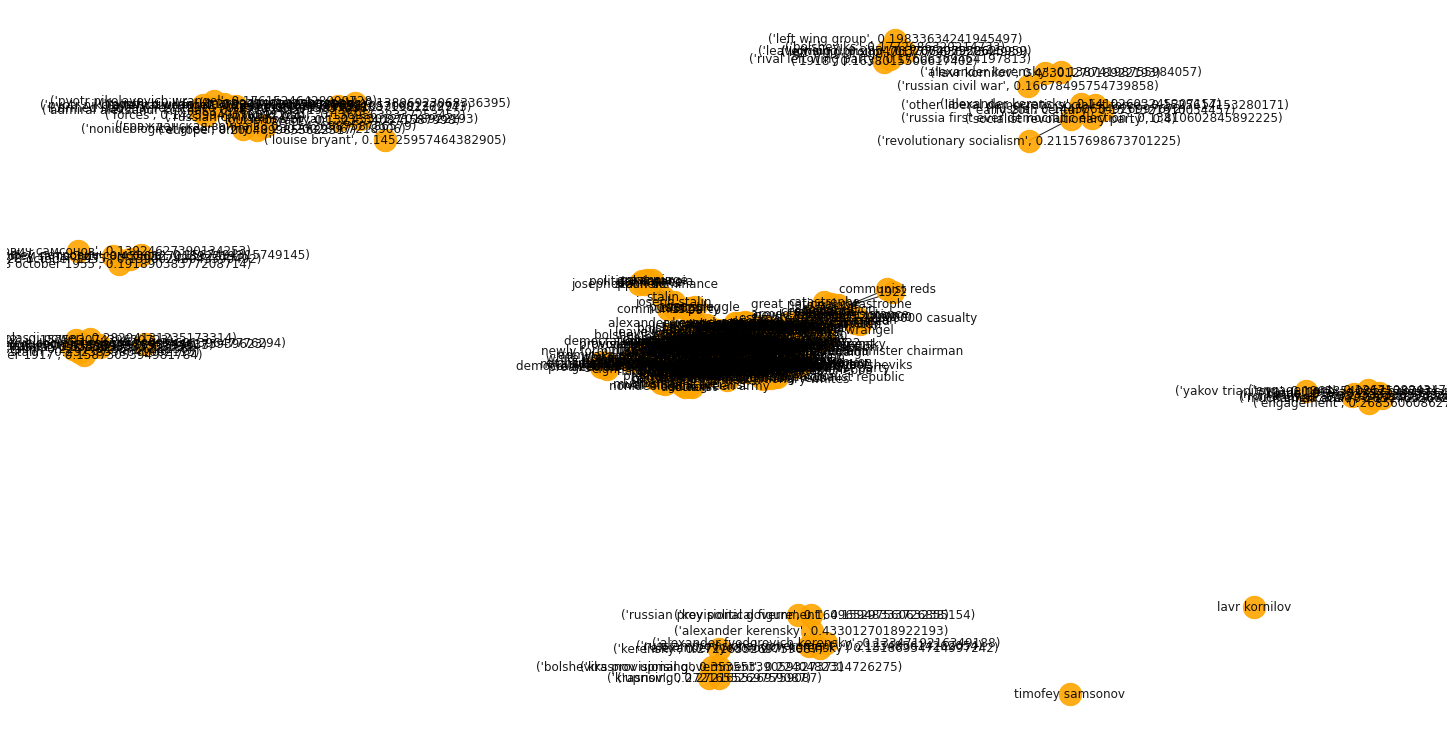

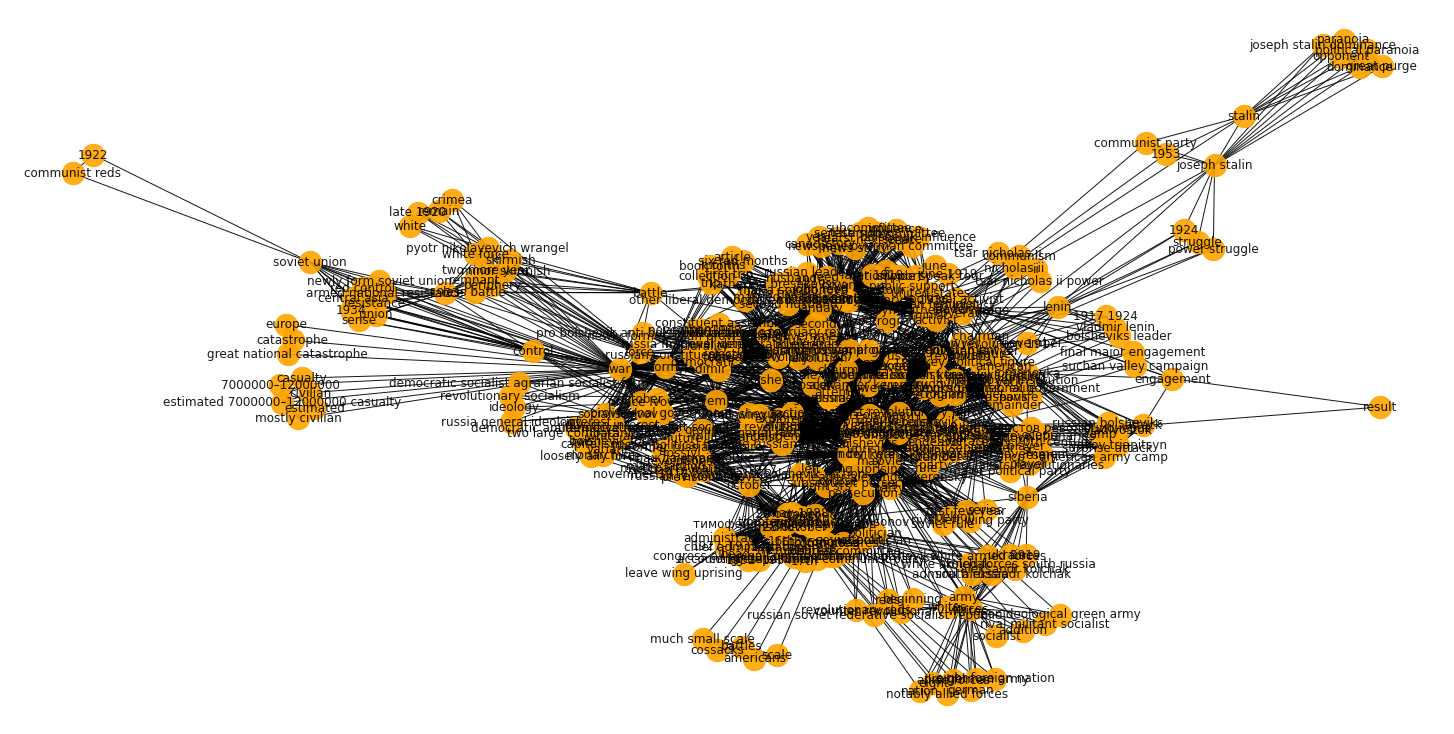

In [28]:
 
    RG = create_relevant_graph(paras_phrases, question_phrases_text)
    RG, common_phrases, mapping = find_common_mapping(RG, question_phrases_text)# mapping matchs paras_phrases with question_phrases
 
    RG, dup_sets = dedup_nodes_in_graph(RG, question_phrases_text)              # dedup paras_phrases in RG for finding meanningful path
#     print(black("nodes in RG: ", 'bold'), RG.nodes())
    
    question_only_phrase = list(set(question_phrases_text).difference(common_phrases)) 
    if(len(common_phrases) > 1): 
        path_phrases = list(approx.steinertree.steiner_tree(RG, common_phrases).nodes)  # to find the shortest path cover all common_phrases  
        extended_phrases = path_phrases + question_only_phrase  
    else: #  0 or 1 common phrases
        path_phrases = list(common_phrases)             
        extended_phrases = question_phrases_text
    
    
    
    print(black("common_phrases: ", 'bold'), common_phrases)
    print(black("path_phrases: ", 'bold'), path_phrases)     
    print(black("question_only_phrase: ", 'bold'), question_only_phrase)
    print(black("extended_phrases before expand", 'bold'), extended_phrases)
    

In [29]:
    # expand to include previously mapped nodes 
    reversed_mapping = {} 
    for k,v in mapping.items():
        if v in reversed_mapping:
            reversed_mapping[v].append(k)
        else:
            reversed_mapping[v] = [k] 
    for phrase in extended_phrases:
        if phrase in reversed_mapping:
            extended_phrases.extend(reversed_mapping[phrase])

In [30]:
    # expand to include merged nodes, that is, also include phrases that from the same dup_set 
    extended_phrases_merged = set()
    for phrase in extended_phrases:
        idx_phrase = [idx for idx, dup_set in enumerate(dup_sets) if(phrase in dup_set)]   # the set where phrase in
        if(len(idx_phrase) > 0):
            extended_phrases_merged = extended_phrases_merged | dup_sets[idx_phrase[0]]
            extended_phrases_merged.remove(phrase)
    extended_phrases.extend(list(extended_phrases_merged))
    print(black("extended_phrases: ", 'bold'), extended_phrases)        
    print(black("introduced_phrases: ", 'bold'), set(extended_phrases) - set(question_phrases_text))
        

extended_phrases:  ['civil war', 'alexander kerensky', 'bolsheviks', 'course', 'russian civil war', 'ensue russian civil war', 'provisional government leader alexander kerensky', 'kerensky', 'alexander kerensky provisional government', 'alexander fyodorovich kerensky', 'bolsheviks leader', 'russian bolsheviks', 'bolsheviks provisional government', 'congress all union communist party bolsheviks', 'war']
introduced_phrases:  {'congress all union communist party bolsheviks', 'bolsheviks leader', 'alexander fyodorovich kerensky', 'provisional government leader alexander kerensky', 'bolsheviks provisional government', 'russian civil war', 'russian bolsheviks', 'alexander kerensky provisional government', 'ensue russian civil war', 'kerensky'}


nodes to draw ['civil war', 'alexander kerensky', 'bolsheviks', 'course']


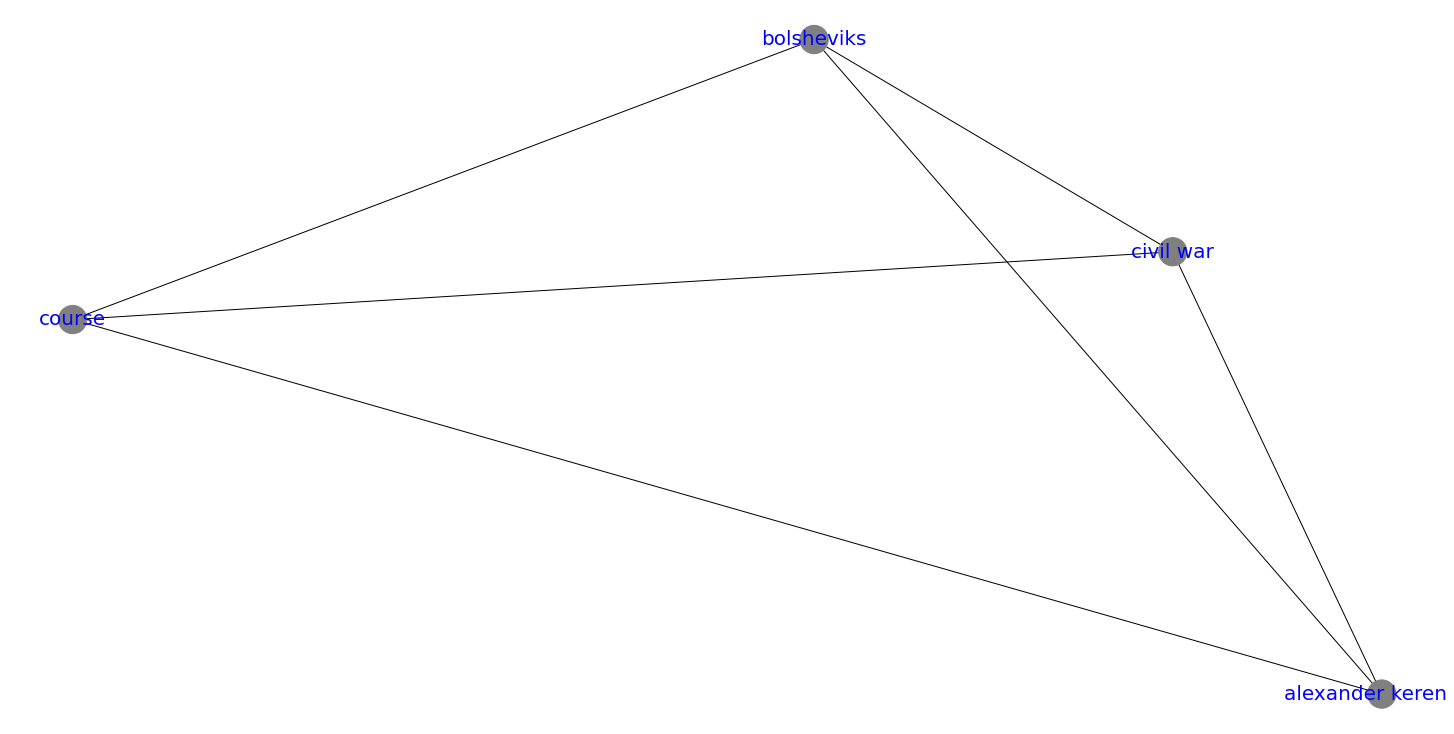

(civil war, bolsheviks, {'src': [(0, 6), (1, 4), (3, 1), (3, 3)]})
(civil war, alexander kerensky, {'src': [(9, 2)]})
(civil war, course, {'src': [(0, 6)]})
(civil war, civil war, {'src': [(2, 1)]})
(alexander kerensky, bolsheviks, {'src': [(6, 1)]})
(alexander kerensky, alexander kerensky, {'src': [(9, 5)]})
(alexander kerensky, civil war, {'src': [(9, 2)]})
(alexander kerensky, course, {'src': [(0, 6)]})
(bolsheviks, alexander kerensky, {'src': [(6, 1)]})
(bolsheviks, civil war, {'src': [(0, 6), (1, 4), (3, 1), (3, 3)]})
(bolsheviks, course, {'src': [(0, 6)]})
(bolsheviks, bolsheviks, {'src': [(8, 2)]})
(course, bolsheviks, {'src': [(0, 6)]})
(course, alexander kerensky, {'src': [(0, 6)]})
(course, civil war, {'src': [(0, 6)]})
nodes to draw ['civil war', 'course', 'bolsheviks', 'alexander kerensky']


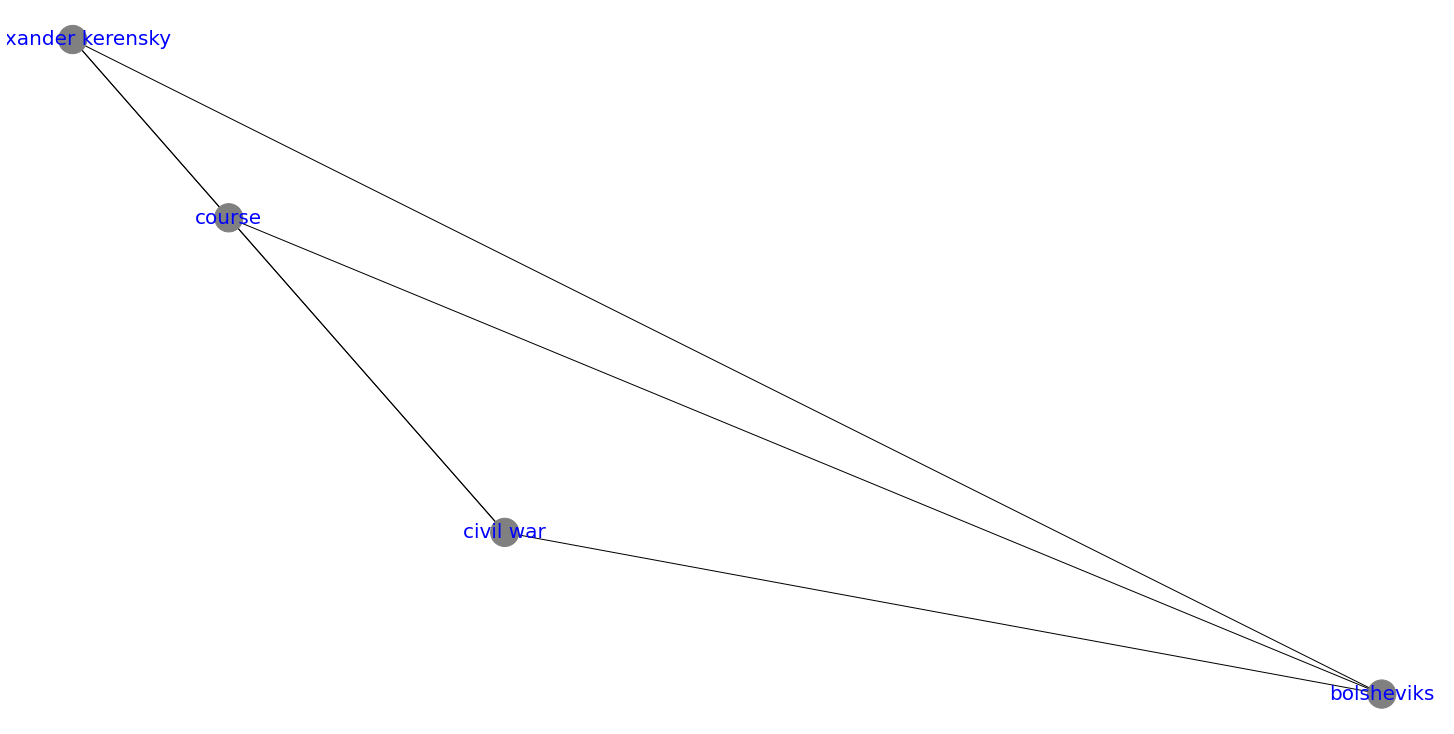

(civil war, bolsheviks, {'src': [(0, 6), (1, 4), (3, 1), (3, 3)]})
(civil war, alexander kerensky, {'src': [(9, 2)]})
(civil war, course, {'src': [(0, 6)]})
(civil war, civil war, {'src': [(2, 1)]})
(course, bolsheviks, {'src': [(0, 6)]})
(course, alexander kerensky, {'src': [(0, 6)]})
(course, civil war, {'src': [(0, 6)]})
(bolsheviks, alexander kerensky, {'src': [(6, 1)]})
(bolsheviks, civil war, {'src': [(0, 6), (1, 4), (3, 1), (3, 3)]})
(bolsheviks, course, {'src': [(0, 6)]})
(bolsheviks, bolsheviks, {'src': [(8, 2)]})
(alexander kerensky, bolsheviks, {'src': [(6, 1)]})
(alexander kerensky, alexander kerensky, {'src': [(9, 5)]})
(alexander kerensky, civil war, {'src': [(9, 2)]})
(alexander kerensky, course, {'src': [(0, 6)]})


In [31]:
    vis_graph(RG, common_phrases, question_phrases_text) 
#     print(blue("Min Subgraph covers all common entities"))
    vis_graph(RG, path_phrases, question_phrases_text) 
        
#     print(black("phrases in relevant components", 'bold'))    
#     print(RG.nodes.data())
        
    

In [32]:
    
    raw_reduced_contexts, kept_para_sent = construct_reduced_context(raw_contexts, paras_phrases, extended_phrases, mapping)     
    reduced_contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_reduced_contexts]    
    reduced_context_str = _normalize_text(" ".join(reduced_contexts)) 
    if (answer != '' and answer != 'yes'  and  answer != 'no' and len(list(re.finditer(answer, reduced_context_str, re.IGNORECASE))) > 0):
        print(black("answer in reduced_context", 'bold')) 
    elif(answer == 'yes' or answer == 'no'):
        pass
    else:
        print(black("answer not in reduced_context", 'bold')) 
#         print(black("reduced_contexts", 'bold'), raw_reduced_contexts)
#     print(black('titles: ', 'bold'), titles) 
    
    reduced_supporting_facts, reduced_supporting_facts_in_original_sentId = construct_reduced_supporting_facts(example["supporting_facts"], raw_reduced_contexts, kept_para_sent) 

    print(black('reduced_supporting_facts_in_original_sentId: ', 'bold'), reduced_supporting_facts_in_original_sentId) 
#     print(black('reduced supportiing facts: ', 'bold'), reduced_supporting_facts) 
    for para_title, sent_id in reduced_supporting_facts_in_original_sentId:
        print(raw_contexts[titles.index(para_title)][1][sent_id])
    
    example["question_phrases_text"] = question_phrases_text
    example["question_only_phrase"] = question_only_phrase
    P = RG.subgraph(path_phrases)  # to save the graph view that contains      
    path_data = json_graph.node_link_data(P)
    example["path"] = path_data
    example["question_phrases"] = question_phrases
    example["paras_phrases"] = paras_phrases
#     example["all_sent_phrases_text"] = all_sent_phrases_text
    example["common_phrases"] = list(common_phrases)
    example["path_phrases"] = path_phrases
    example["extended_phrases"] = extended_phrases                     
    example['context'] = raw_reduced_contexts
    example['supporting_facts'] = reduced_supporting_facts
    example['kept_para_sent'] = kept_para_sent

    print(black("context: ", 'bold'), raw_contexts)   
    print(black("reduced_context: ", 'bold'), raw_reduced_contexts)   

reduced_context_ratio 0.6346153846153846
answer in reduced_context
supportiing facts:  {('Socialist Revolutionary Party', 5), ('Russian Civil War', 0)}
reduced_supporting_facts_in_original_sentId:  [['Socialist Revolutionary Party', 5], ['Russian Civil War', 0]]
 The anti-Bolshevik faction of this party, known as the Right SRs, which remained loyal to the Provisional Government leader Alexander Kerensky was defeated and destroyed by the Bolsheviks in the course of the Russian Civil War and subsequent persecution.
The Russian Civil War (Russian: Гражда́нская война́ в Росси́и , "Grazhdanskaya voyna v Rossiyi" ; November 1917 – October 1922) was a multi-party war in the former Russian Empire immediately after the Russian Revolutions of 1917, as many factions vied to determine Russia's political future.
context:  [['Socialist Revolutionary Party', ['The Socialist Revolutionary Party, or Party of Socialists-Revolutionaries (the SRs; Russian: Партия социалистов-революционеров (ПСР), эсеры , 

### Sandbox

In [33]:
sandbox, do not run

SyntaxError: invalid syntax (<ipython-input-33-9c04175d57a7>, line 1)

In [ ]:
import imp
imp.find_module('pytextrank')

#### Not able to resolve phrase in the title

In [ ]:
title = "chris jones footballer born 1985"
sents =  ['chris is welsh semiprofessional footballer currently playing for cymru alliance side porthmadog', 'former professional with leeds united jones is currently in his fourth season with city', 'he made several appearances for leeds and was heavily involved with first team', 'chris was playing with likes of aaron lennon james milner rio ferdinand scott carson and alan smith during his spell with yorkshire outfit']

In [ ]:
context = title  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(sents)

In [ ]:
context_doc = nlp1(context)
title, sents = context_doc._.coref_resolved.split(TITLE_END)  
sents = sents.split(SENT_MARKER_END)
sent_docs = list(nlp2.pipe([title] + sents))     

In [ ]:
context_doc._.coref_resolved

#### fishing lake VS lake

In [ ]:
context = "brown state fishing lake , </t> .  brown state fishing lake sometimes also known as brown state fishing lake and wildlife area is protected area in brown county kansas in united states , </sent> ,  lake is 62 acres 025 km² in area and up to 13 feet 4 m deep , </sent> ,  area was formerly known as brown county state park and is 8 miles 13 km east of hiawatha kansas"
 

In [ ]:
context_doc = nlp1(context)
print(context_doc._.coref_resolved)
print(context_doc._.coref_clusters)
print(context_doc._.coref_clusters[1].mentions)
print(context_doc._.coref_clusters[1].mentions[-1])
print(context_doc._.coref_clusters[1].mentions[-1]._.coref_cluster.main)

In [ ]:
context = "fishing lake , </t> .  fishing lake is lake in canadian province of saskatchewan , </sent> ,  lake is located between highway 5 and highway 16 22 km north of town of foam lake saskatchewan and 24 km east of town of wadena saskatchewan , </sent> ,  lake does not have effective outlet channel and so is prone to flooding , </sent> ,  record floods in 2007 resulted in plan by government of saskatchewan to lower level of lake by digging drainage channel , </sent> ,  fishing lake first nation opposed this plan and instead flood control berms were constructed"
context_resolved = nlp1(context)._.coref_resolved

print(context_resolved)
title_coref_resolved, sents_coref_resolved = context_resolved.split(TITLE_END)  
sents_coref_resolved = sents_coref_resolved.split(SENT_MARKER_END) 
sent_docs = list(nlp2.pipe([title_coref_resolved] + sents_coref_resolved))     
para_phrases = []                                        
for sent_doc in sent_docs:                                    # each sent in a para
    sent_phrases = [(p.text, p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
    para_phrases.append(sent_phrases)     
print(para_phrases)
print("\n")  

#### noun_chunks VS root

In [ ]:
from spacy.tokens import Span
text = 'valhalla highlands historic district also known as lake valhalla is national historic district located near cold spring in putnam county new york'
doc = nlp2(text)
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text)
#     span = Span(doc, chunk.root.i, chunk.root.i+1)
#     print(span)
#     print(span.start)

In [ ]:
text = "Athenion was in the late 30s BC a military commander of the Egyptian queen Cleopatra in Coele-Syria,"
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text) 

spacy 2.3.5 did not recognize `military commander` in the sentence above as a noun_chunk

In [ ]:
text = "Neil Mallon Pierce Bush (born January 22, 1955) is the fourth of six children of former President George H, W, Bush and Barbara Bush (née Pierce),"
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)
# for chunk in doc.noun_chunks:
#     print('chunk: ', chunk.text) 
#     print('root: ',  chunk.root.text) 

#### noun_chunks VS ner

In [ ]:
text = "Alice David is the voice of Lara Croft in a video game developed by which company ?"
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)

In [ ]:
text = 'Alice David is the voice of Lara Croft in a video game developed by which company ?'
doc = nlp1(text)
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text) 

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

In [ ]:
for chunk in doc.noun_chunks:
    if(chunk.text not in [entity.text for entity in doc.ents]):
        print('chunk: ', chunk.text) 

In [ ]:
text = "General Mills, Inc is headquartered in Golden Valley, Minnesota, a suburb of Minneapolis"
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)

In [ ]:
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text) 

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

#### hierarchical noun_chunk

In [ ]:
text = '"Tomb Raider III" is the third title in the "Tomb Raider" video game series and a sequel to "Tomb Raider II".'
basic_normalize(text)

In [ ]:
doc = nlp2(basic_normalize(text))
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 

#### neil mallon pierce bush VS neil bush

In [ ]:
phrase = 'neil mallon pierce bush' 
rest_phrases = [p for p in list(RG.nodes()) if p!=phrase]
inclusion_similar_phrase = inclusion_best_match(phrase, rest_phrases)
inclusion_similar_phrase

#### 500-Mile VS 500 Mile

In [ ]:
text = "The 41st International 500-Mile Sweepstakes was held at the Indianapolis Motor Speedway on Thursday, May 30, 1957, "
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)

In [ ]:
text = "The 41st International 500 Mile Sweepstakes was held at the Indianapolis Motor Speedway on Thursday, May 30, 1957, "
doc = nlp2(text)
for p in doc._.phrases: 
    if(p.text != ''):
        print(_normalize_text(p.text.lower()), p.rank)

#### Partial match threshold

In [ ]:
query = '41st international 500 mile sweepstakes' 
choices = ['500 mile', 'race track', 'midwest', 'host', 'track', 'midwest host']
inclusion_phrases = [simi_phrase for (simi_phrase, similarity) in process.extractBests(query, choices, scorer=fuzz.token_set_ratio) if similarity ==100]  # match '1977 film' and '1977', but will not match substring 'woman' and 'businesswoman', avid nosiy such as 'music' and 'us'
inclusion_phrases

In [ ]:
simi_phrase, similarity = process.extractOne(query, inclusion_phrases, scorer=fuzz.ratio) # most similar   
simi_phrase, similarity

In [ ]:
query = 'tomb raider video game series'
choices = ['tomb raider ii', 'raider', 'tomb raider franchise', 'trademark', 'simply tomb raider iii', 'tomb raider iii', 'simply tomb raider', 'tomb raider series', 'tomb raider trademark', 'tomb raider brand', 'tomb raider', 'tomb']
inclusion_phrases = [simi_phrase for (simi_phrase, similarity) in process.extractBests(query, choices, scorer=fuzz.token_set_ratio) if similarity ==100]  # match '1977 film' and '1977', but will not match substring 'woman' and 'businesswoman', avid nosiy such as 'music' and 'us'
inclusion_phrases

In [ ]:
simi_phrase, similarity = process.extractOne(query, inclusion_phrases, scorer=fuzz.ratio) # most similar   
simi_phrase, similarity

In [ ]:
simi_phrase, similarity = process.extractOne("first time", ["time"], scorer=fuzz.ratio) # most similar 
simi_phrase, similarity

In [ ]:
query ='companion book'
choices = ['second companion book']
simi_phrase, similarity = process.extractOne(query, choices, scorer=fuzz.ratio) # most similar   
simi_phrase, similarity

In [ ]:
len(query.split())

In [ ]:
len(simi_phrase.split())

In [ ]:
inclusion_best_match(query, choices)

#### Poor coref resolution

In [ ]:
text = "Buddy (August 7, 1997 – January 2, 2002), a male chocolate-colored Labrador Retriever, was one of two pets kept by the Clinton family while Bill Clinton was President of the United States, , </sent> , The Clintons' other pet was a cat named Socks,"
doc = nlp1(text)
doc._.coref_resolved

In [ ]:
text = "Neil Mallon Pierce Bush (born January 22, 1955) is an American businessman and investor, , </sent> , He is the fourth of six children of former President George H, W, Bush and Barbara Bush (née Pierce), , </sent> , His five siblings are George W, Bush, the 43rd President of the United States; Jeb Bush, a former governor of Florida; Robin Bush, died of leukemia at the age of three; Marvin; and Dorothy, , </sent> , Neil Bush is currently a businessman based in Texas," 
doc = nlp1(text)
doc._.coref_resolved

#### Draw interested nodes and neighbors

In [ ]:
vis_graph(RG, ['chokwe lumumba', 'mayor', 'jackson', 'mississippi', '2017', 'jackson mississippi mayor', 'father'], question_phrases_text)

In [ ]:
common_phrases_neighbors = {}
for n, nbrs in RG.adj.items():  # each node and its neighbors   
    if(n in common_phrases): 
        li = []
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            li.append(nbr) 
        common_phrases_neighbors[n] = li
print('len(common_phrases): ', len(common_phrases))
# ['chokwe lumumba' in comm_neighbors for comm, comm_neighbors in common_phrases_neighbors.items()].count(True)
['princess victoria melita' in comm_neighbors for comm, comm_neighbors in common_phrases_neighbors.items()].count(True)

In [ ]:
satellite_nodes = []    # nodes one-hop away from more than half of common_phrases
for node in RG.nodes():
    if([node in comm_neighbors for comm, comm_neighbors in common_phrases_neighbors.items()].count(True) >= len(common_phrases)*3/4 and node not in question_phrases_text):
        satellite_nodes.append(node)
print(satellite_nodes)

In [ ]:
list(common_phrases) + satellite_nodes

#### appositive noun phrase coref resolution

In [ ]:
text = "Princess Marie-Cécile of Prussia (Marie-Cécile Kira Viktoria Luise; born 28 May 1942 in Cadinen, Kreis Elbing) is the daughter of Louis Ferdinand, Prince of Prussia, and his wife is Grand Duchess Kira Kirillovna of Russia. Her paternal grandparents were William, German Crown Prince, and Duchess Cecilie of Mecklenburg-Schwerin; maternally, she is a granddaughter of Cyril Vladimirovich, Grand Duke of Russia, and Princess Victoria Melita of Saxe-Coburg and Gotha"
doc = nlp1(text)
doc._.coref_resolved

In [ ]:
sents_coref_resolved = ['Princess Marie-Cécile of Prussia (Marie-Cécile Kira Viktoria Luise; born 28 May 1942 in Cadinen, Kreis Elbing) is the daughter of Louis Ferdinand, Prince of Prussia, and Princess Marie-Cécile of Prussia wife, Grand Duchess Kira Kirillovna of Russia,', 'Princess Marie-Cécile of Prussia paternal grandparents were William, German Crown Prince, and Duchess Cecilie of Mecklenburg-Schwerin; maternally, Princess Marie-Cécile of Prussia is a granddaughter of Cyril Vladimirovich, Grand Duke of Russia, and Princess Victoria Melita of Saxe-Coburg and Gotha,']

sent_docs = list(nlp2.pipe(["Princess Marie Cécile of Prussia"] + sents_coref_resolved))
           
for sent_doc in sent_docs:                                      # each sent in a para 
    sent_phrases_text = [_normalize_text(p.text)  for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
    print(sent_phrases_text)

#### dedup

In [ ]:
dup_sets =  [{'16 november', '16 november 1930'}, {'3', '3–2'}]
dup_sets.append(set(['time', 'first time']))
dup_sets

In [ ]:
x = set([1,2,3])
x.add(4)
x

In [ ]:
'time' in {'first time', 'time'}

In [ ]:
'tim' in {'first time', 'time'}

#### revert mapping

In [ ]:
list(mapping.items())

In [ ]:
mapping.values()

In [ ]:
reversed_mapping = {} 
for k,v in mapping.items():
    if v in reversed_mapping:
        reversed_mapping[v].append(k)
    else:
        reversed_mapping[v] = [k]
reversed_mapping    